# Discrete sampling
### Magdalena Augustyńska

**Problem 2c (Squaring the histogram).** In this problem, we again want to sample with known probabilities $p_1,\ldots,p_n$, but this time we make no assumptions on $p_i$. Consider the following algorithm:
   * Let $V$ be the mean of $p_i$, i.e. $V=\frac{1}{n}$.
   * Create $n$ buckets, each with volume $V$, put each $p_i$ into a separate bucket.
   * Until there exists a bucket $A$ that is not full, find a bucket $B$ that overflows, and trasfer probability from $B$ to $A$ until $A$ is exactly full

Show that:
   * This algorithm always ends.
   * When it ends, each bucket contains pieces of exactly two $p_i$'s.

How to use the result of this algorithm to sample with probabilities $p_i$. Argue that your algorithm is correct and implement it. The sampling part should be *vectorized*. Use this algorithm to sample birthdates again, and test its efficiency.

## **Solution.**

*Show that this algorithm always ends.*

Let $n_{1}$ be the number of buckets that are not full, $n_{2}$ number of overflowed buckets and $n_{3}$ buckets that are exactly full. 
After each iteration of the while loop underflowed bucket becomes full bucket and additionally overflowed bucket becomes full or underflowed or stays overflowed. 
It means that throughout the algorithm we had overall at most n buckets that must have been filled due to underflow and after each iteration number of underflowed buckets decreases.  
Therefore, after (at most) $n$ iterations there will be 0 underflowed buckets. Let's assume that there is any bucket that is overflowed. If so, the sum of all buckets' content would exceed 1 which implies contradiction.

*Show that when it ends, each bucket contains pieces of exactly two $p_i$'s.*

If a bucket had $p_i$ smaller than V in the beginning of algorithm then it was supplemented with part of another bucket so it contains two $p_i$'s. Otherwise, the value in bucket was at some moment decreased and transferred to another bucket. If the value decreased below V then it must have been complemented so the bucket also contains two $p_i$'s.
There can be also buckets whose initial content is V or whose content after transferring probability to another bucket became exactly V. In that case there is only one $p_i$ in these buckets.

*Algorithm implementation*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from random import randint
import time

In [2]:
def simulate(probabilities):
    V = np.mean(probabilities)
    days = len(probabilities)
    buckets = np.empty(days, dtype=list)
    for i in range(days):
        bucket = [[i+1], [probabilities[i]]]
        buckets[i] = bucket 
                          
    while True:
        A_index = next((index for index, value in enumerate(buckets) if len(value[0]) == 1 and value[1][0] < V), None)
        B_index = next((index for index, value in enumerate(buckets) if len(value[0]) == 1 and value[1][0] > V), None)
        if A_index is None or B_index is None:
            break
        to_transfer = V - buckets[A_index][1][0]
        buckets[A_index][1].append(to_transfer)
        buckets[A_index][0].append(buckets[B_index][0][0])
        buckets[B_index][1][0] -= to_transfer
    return buckets

This algorithm can be used to sample day with given probability in constant time instead of linear. First we sample one of the bucket with uniform probability. If the drawn bucket wasn't complemeneted with another bucket's content throughout the algorithm we take the day represented by the bucket as the result of sampling. 
Otherwise, we sample one of the days whose probabilities are contained in the bucket, with probability assigned to the day that is contained in the bucket.
This algorithm is indeed correct - every day can be drawn by drawing one of buckets containing its part of probability and then drawing the specific day out of at most 2.  
If in the beginning of the algorithm probability $p_i$ is smaller than V then in the end it contains another probability in its bucket. In that case we sample this day with probability $\frac{1}{n} * \frac{p_i}{V} = p_i$.
Otherwise, if $p_i$ is bigger than V, it must have been splitted between several buckets. Let's say that $p_i$ has been splitted in following parts $p_i = p_{i1} + p_{i2} + ... + p_{ik}$. Then probability of drawing each part is $\frac{1}{n} * \frac{p_{ij}}{V} = p_{ij}$. So the probability of drawing i-th day is $\sum_{j=1}^{k} p_{ij} = p_i$.

*Function sampling one day using algorithm based on buckets.*

In [3]:
def sample_from_buckets(buckets):
    day = np.random.randint(len(buckets))
    if len(buckets[day][0]) == 1:
        return buckets[day][0][0]
    else:
        return np.random.choice(buckets[day][0], 1, p = [p/sum(buckets[day][1]) for p in buckets[day][1]])[0]

*An attempt to make vectorized version.*

In [4]:
def sample_from_buckets_vec(buckets, size):
    days_numbers = np.random.randint(len(buckets), size=size)
    result = np.empty(size)
    sampled_days = buckets[days_numbers]
    prob = [sampled_days[i][1]/sum(sampled_days[i][1]) for i in range(size)]
    for i in range(len(prob)):
        if prob[i].shape[0] == 1:
            prob[i] = np.pad(prob[i], pad_width=(0, 1), mode='constant')
    prob = np.array(prob)
    days = np.array([sampled_days[i][0] for i in range(size)])
    c = prob.cumsum(axis=1)
    u = np.random.rand(len(c), 1)
    choices = (u < c).argmax(axis=1)
    result = [days[i][choice] for i, choice in enumerate(choices)]
    return result

*Function, that chooses random dates until a repeat occurs.*  
The function returns the number of the step in which that happened.

In [5]:
def random_date_buckets(buckets):
    step = 0
    occ = [0] * len(buckets)
    while True:
        step += 1
        random_day = sample_from_buckets(buckets)
        if (occ[random_day - 1]) == 1:
            return step
        else:
            occ[random_day-1] += 1

*With vectorized version.*

In [6]:
def random_date_buckets_vec(buckets):
    step = 0
    occ = [0] * len(buckets)
    random_days = sample_from_buckets_vec(buckets, 10)
    while True:
        if step%10 == 0:
            random_days = sample_from_buckets_vec(buckets, 10)
        day = random_days[step%10]
        step += 1
        if (occ[day - 1]) == 1:
            return step
        else:
            occ[day-1] += 1

*Sampling birthdates using supplied data.*

In [7]:
data = pd.read_csv('../../rpis/lab1/us_births_69_88.csv')

In [8]:
all_births = sum(data['births'])

In [9]:
freq = [data['births'][i]/all_births for i in range(data.shape[0])]

In [10]:
buckets = simulate(freq)

In [11]:
buckets

array([list([[1, 14], [0.002275172033559089, 0.000413000009451664]]),
       list([[2, 20], [0.0024103325942891394, 0.00027783944872161346]]),
       list([[3, 21], [0.0025541898511173863, 0.00013398219189336659]]),
       list([[4, 22], [0.002594169116377939, 9.400292663281403e-05]]),
       list([[5, 27], [0.0026124846704770775, 7.568737253367541e-05]]),
       list([[6, 28], [0.0026491015915691587, 3.9070451441594167e-05]]),
       list([[7, 33], [0.002671105793279278, 1.7066249731474692e-05]]),
       list([[8, 34], [0.0026272534480271965, 6.091859498355643e-05]]),
       list([[9, 35], [0.002575115832756604, 0.000113056210254149]]),
       list([[10, 41], [0.0026057174208215473, 8.245462218920557e-05]]),
       list([[11, 42], [0.002653073981304061, 3.509806170669174e-05]]),
       list([[12, 42], [0.002667629952261239, 2.0542090749513936e-05]]),
       list([[13, 43], [0.002684228866510652, 3.943176500100735e-06]]),
       list([[14, 43], [0.002320117625010678, 0.0003680544180000

In [12]:
N = 1000

In [13]:
start = time.time()
result_buckets = [random_date_buckets(buckets) for i in range(N)]
end = time.time()
print("Algorithm was executed in ", (end-start), " sec.")

Algorithm was executed in  2.3377230167388916  sec.


(array([11., 19., 15., 30., 22., 44., 28., 64., 30., 67., 39., 64., 27.,
        58., 35., 50., 31., 53., 22., 42., 19., 43., 28., 31.,  6., 26.,
        19., 10., 13.,  7., 13.,  6.,  7.,  2.,  2.,  2.,  5.,  0.,  1.,
         1.,  2.,  0.,  1.,  0.,  1.,  0.,  3.,  0.,  0.,  1.]),
 array([ 2.  ,  3.52,  5.04,  6.56,  8.08,  9.6 , 11.12, 12.64, 14.16,
        15.68, 17.2 , 18.72, 20.24, 21.76, 23.28, 24.8 , 26.32, 27.84,
        29.36, 30.88, 32.4 , 33.92, 35.44, 36.96, 38.48, 40.  , 41.52,
        43.04, 44.56, 46.08, 47.6 , 49.12, 50.64, 52.16, 53.68, 55.2 ,
        56.72, 58.24, 59.76, 61.28, 62.8 , 64.32, 65.84, 67.36, 68.88,
        70.4 , 71.92, 73.44, 74.96, 76.48, 78.  ]),
 <a list of 50 Patch objects>)

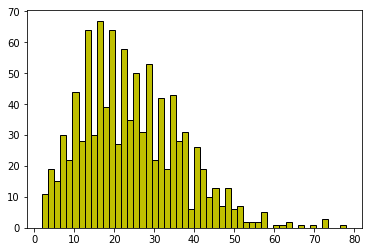

In [14]:
plt.hist(result_buckets, color='y', bins=50, edgecolor = 'black')

*Vectorized version.*

In [15]:
start = time.time()
result_buckets_vec = [random_date_buckets_vec(buckets) for i in range(N)]
end = time.time()
print("Algorithm was executed in ", (end-start), " sec.")

Algorithm was executed in  0.7676372528076172  sec.


Vectorized version of algorithm executes much faster.

(array([12., 17., 12., 39., 21., 38., 36., 62., 31., 55., 28., 69., 31.,
        73., 29., 65., 32., 49., 20., 42., 19., 40., 12., 33., 14., 25.,
        15.,  5., 13.,  6., 16.,  4.,  6.,  7.,  8.,  1.,  4.,  1.,  3.,
         2.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.]),
 array([ 2.  ,  3.52,  5.04,  6.56,  8.08,  9.6 , 11.12, 12.64, 14.16,
        15.68, 17.2 , 18.72, 20.24, 21.76, 23.28, 24.8 , 26.32, 27.84,
        29.36, 30.88, 32.4 , 33.92, 35.44, 36.96, 38.48, 40.  , 41.52,
        43.04, 44.56, 46.08, 47.6 , 49.12, 50.64, 52.16, 53.68, 55.2 ,
        56.72, 58.24, 59.76, 61.28, 62.8 , 64.32, 65.84, 67.36, 68.88,
        70.4 , 71.92, 73.44, 74.96, 76.48, 78.  ]),
 <a list of 50 Patch objects>)

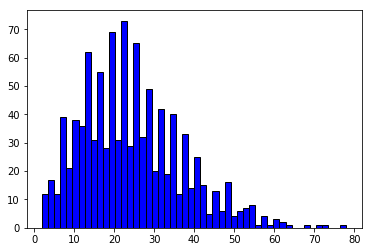

In [16]:
plt.hist(result_buckets_vec, color='b', bins=50, edgecolor = 'black')

To test the efficiency of the algorithm, let's compare it with linear sampling method provided by the Python library.

In [17]:
def random_date(freq):
    step = 0
    d = len(freq)
    occ = [0] * d
    days = range(1, d + 1)
    while True:
        step += 1
        rand = np.random.choice(days, p=freq)
        if (occ[rand -1]) == 1:
            return step
        else:
            occ[rand-1] += 1    

In [18]:
start = time.time()
result = [random_date(freq) for i in range(N)]
end = time.time()
print("Algorithm was executed in ", (end-start), " sec.")

Algorithm was executed in  3.8154191970825195  sec.


(array([11.,  7., 21., 22., 25., 44., 30., 21., 51., 39., 31., 49., 36.,
        53., 26., 27., 57., 42., 27., 51., 23., 25., 42., 19., 20., 35.,
        10., 41., 13., 14., 22.,  9.,  8., 12.,  1.,  5.,  8.,  4.,  6.,
         3.,  4.,  1.,  0.,  0.,  2.,  1.,  0.,  1.,  0.,  1.]),
 array([ 2.  ,  3.36,  4.72,  6.08,  7.44,  8.8 , 10.16, 11.52, 12.88,
        14.24, 15.6 , 16.96, 18.32, 19.68, 21.04, 22.4 , 23.76, 25.12,
        26.48, 27.84, 29.2 , 30.56, 31.92, 33.28, 34.64, 36.  , 37.36,
        38.72, 40.08, 41.44, 42.8 , 44.16, 45.52, 46.88, 48.24, 49.6 ,
        50.96, 52.32, 53.68, 55.04, 56.4 , 57.76, 59.12, 60.48, 61.84,
        63.2 , 64.56, 65.92, 67.28, 68.64, 70.  ]),
 <a list of 50 Patch objects>)

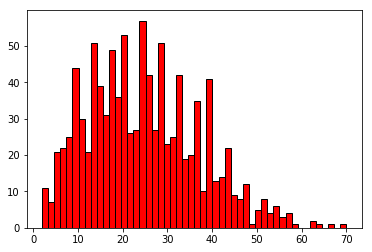

In [19]:
plt.hist(result, color='r', bins=50, edgecolor = 'black')

As we can see, the algoithm using buckets performs better.